## Libraries Import

In [1]:
import math
import statistics as stat
import sklearn.metrics as sk
import pandas as pd
import numpy as np
import altair as alt
from altair import datum
import matplotlib.pyplot as plt
import seaborn as sns                     # for matrix scatter plots
from sklearn.impute import SimpleImputer  # basic imputation method
from sklearn.impute import KNNImputer     # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer # required for MICE imputation
from sklearn.impute import IterativeImputer # MICE imputation

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARMAResults 

In [2]:
import statsmodels

In [3]:
statsmodels.__version__

'0.12.2'

## Data Import
- Rename columns
- Remove irrelavent columns
- Remove irrelavent rows
    - Production wells: leave only 'Producing' wells
- Remove duplicates
- Remove nulls

- Group production and injection data by
    - Year
    - Month

In [4]:
pdf = pd.read_excel('/Users/naish/Desktop/NSC/Oil_Gas_Production_All_Years.xlsx', sheet_name = 'Production')

In [5]:
pdf = pdf[pdf['Reported_Well_Status_A'] == 'Producing']
data = pdf[['Date_Production', 'Oil_bbls']]
data.columns = ['Date', 'Prod']
data = data.set_index('Date')
data = data.fillna(0)
data = data[data['Prod'] != 0]
data.info()

# Grid specificaton
nx = 1000; ny = 1; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
xmin = 0.0; xmax = nx*xsiz; ymin = 0.0; ymax = ny*ysiz; cmap = plt.cm.inferno

# Geostatistical simulation parameters
ndmin = 0; ndmax = 30; radius = 1000; ktype = 0; skmean = 0
tmin = -999; tmax = 999

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77886 entries, 1963-11-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prod    77886 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


## Plot Data
    Then remove outlier around 2019

<AxesSubplot:xlabel='Date'>

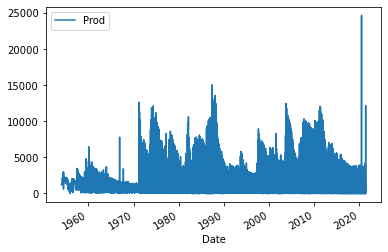

In [6]:
data.plot()

In [7]:
first_quartile = pdf['Oil_bbls'].describe()['25%']
third_quartile = pdf['Oil_bbls'].describe()['75%']
# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Prod'] > (first_quartile - 14 * iqr)) &
            (data['Prod'] < (third_quartile + 14 * iqr))]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77879 entries, 1963-11-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prod    77879 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


<AxesSubplot:xlabel='Date'>

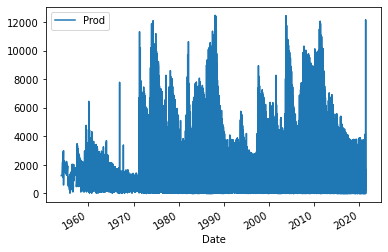

In [8]:
data.plot()

In [9]:
mdata = data.groupby(data.index).sum()

year_prod = data.reset_index()
year_prod['Year'] = year_prod.Date.dt.year
year_prod = (year_prod[['Year','Prod']]).groupby('Year').sum()

month_prod = data.reset_index()
month_prod['Month'] = month_prod.Date.dt.date
month_prod = (month_prod[['Month','Prod']]).groupby('Month').sum()



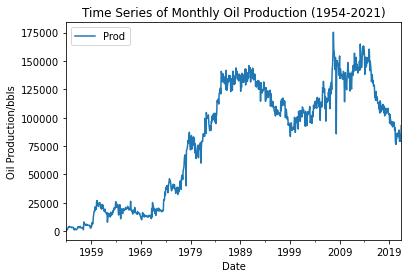

In [10]:
df_l = [mdata, year_prod]
name_l = ['Time Series of Monthly Oil Production (1954-2021)','Time Series of Yearly Oil Production (1954-2021)']
df = df_l[0]['Prod']
def time_vs_var_plot(timeseries, name):
    timeseries.plot()
    plt.ylabel('Oil Production/bbls')
    plt.title(name)  
time_vs_var_plot(df_l[0], name_l[0])

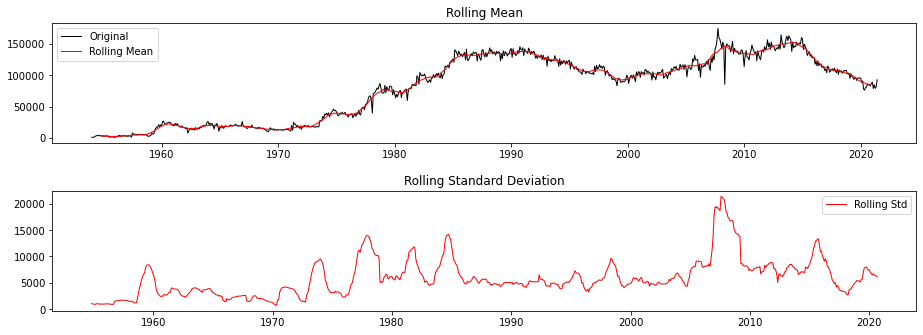

In [11]:
window_size = 20                        # assume window size of 10 days

#Determing rolling statistics
rolling_mean = df_l[0].rolling(window = window_size, center = True).mean()
rolling_std = df_l[0].rolling(window = window_size, center = True).std()
rolling_P025 = df_l[0].rolling(window = window_size, center = True).quantile(.025)
rolling_P975 = df_l[0].rolling(window = window_size, center = True).quantile(.975)

#Plot rolling statistics:
plt.subplot(211)
orig = plt.plot(df_l[0]['Prod'], color='black',linewidth = 1, label='Original')
mean = plt.plot(rolling_mean['Prod'], color='red', linewidth = 1, label='Rolling Mean')
#P025 = plt.plot(rolling_P025, color='grey', linewidth = 1, label='Rolling P025')
#P975 = plt.plot(rolling_P975, color='grey', linewidth = 1, label='Rolling P975')
plt.title('Rolling Mean'); plt.legend(loc='best')
    
plt.subplot(212)
std = plt.plot(rolling_std['Prod'], color='red', linewidth = 1, label = 'Rolling Std')
plt.legend(loc='best'); plt.title('Rolling Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.5, hspace=0.4)

In [12]:
def adf_test(timeseries, name):
    print('Dickey-Fuller Test Results for ' + name)
    dftest = adfuller(timeseries['Prod'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput[0:7])

In [13]:
adf_test(df_l[0], 'Monthly Production')

Dickey-Fuller Test Results for Monthly Production
Test Statistic                  -1.639563
p-value                          0.462489
#Lags Used                      20.000000
Number of Observations Used    789.000000
Critical Value (1%)             -3.438665
Critical Value (5%)             -2.865210
Critical Value (10%)            -2.568724
dtype: float64


In [14]:
def differencing(timeseries, n):
    if n == 0:
        return timeseries
    if n == 1:
        timeseries_new = timeseries.diff()
        timeseries_new = timeseries_new.fillna(timeseries)
        return timeseries_new
    else:
        old = differencing(timeseries, n - 1)
        new = old.diff()
        new = new.fillna(old)
        return new

In [15]:
def get_diff_stationarity(timeseries, log = False, dif = 0):
    if log:
        timeseries = np.log(timeseries)
    timeseries = differencing(timeseries, dif)

    plt.plot(timeseries, color='blue', label='Original')
    plt.legend(loc='best')
    plt.show()
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Prod'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print()

In [16]:
def pacf_n_acf_plots(timeseries, log = 0, dif = 0):
    if log:
        timeseries = np.log(timeseries)
    timeseries = differencing(timeseries, dif)
    plot_acf(timeseries)
    plt.title('ACF: ' + str(dif) + 'th Differencing')
    plot_pacf(timeseries)
    plt.title('PACF: ' + str(dif) + 'th Differencing')

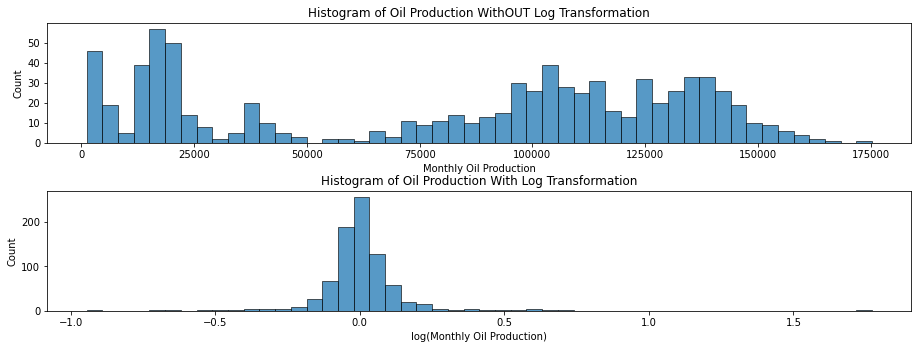

In [17]:
plt.subplot(211)
plt1 = sns.histplot(month_prod.Prod, bins = 50)
plt.title('Histogram of Oil Production WithOUT Log Transformation')
plt.xlabel('Monthly Oil Production')

plt.subplot(212)
plt2 = sns.histplot(np.log(month_prod.Prod).diff(), bins = 50)
plt.title('Histogram of Oil Production With Log Transformation')
plt.xlabel('log(Monthly Oil Production)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.5, hspace=0.4)

0th Differencing With Log Transformation


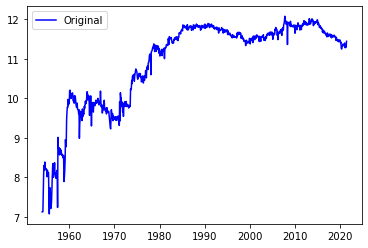

ADF Statistic: -3.813054261374749
p-value: 0.002776541472863368
Critical Values:
	1%: -3.4386757994332813
	5%: -2.865214793881868
	10%: -2.5687268080213355

1th Differencing With Log Transformation


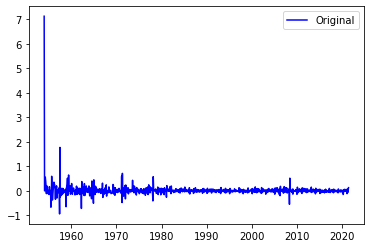

ADF Statistic: -8.547455541245201
p-value: 9.418689554940916e-14
Critical Values:
	1%: -3.4386126789104074
	5%: -2.865186972298872
	10%: -2.5687119871327146

2th Differencing With Log Transformation


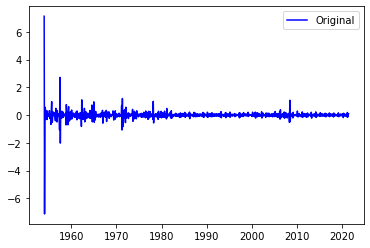

ADF Statistic: -12.623158323599343
p-value: 1.5622004544266784e-23
Critical Values:
	1%: -3.4386441190814265
	5%: -2.8652008302305316
	10%: -2.568719369407094



In [18]:
for i in range(3):
    print(str(i) + 'th Differencing With Log Transformation')
    get_diff_stationarity(month_prod, log = True, dif = i)

In [19]:
df_l[0]['rolling_mean'] = rolling_mean['Prod'].values
df_l[0]['residual'] = df_l[0]['Prod'].values - rolling_mean['Prod'].values
df_l[0]['residual'] = df_l[0]['residual'][~pd.isnull(df_l[0]['residual'])]   # remove null values

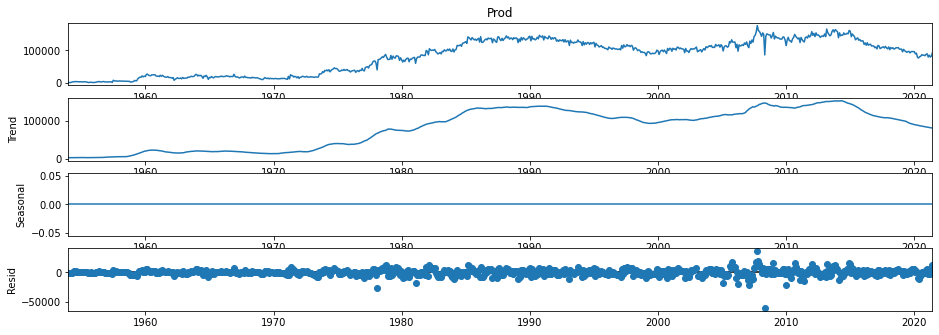

In [20]:
decomposition = seasonal_decompose(df_l[0]['Prod'], model='additive',extrapolate_trend=1,filt=np.ones(20)/20,two_sided = True, period = 1)
decomp_trend = decomposition.trend; decomp_seasonal = decomposition.seasonal; decomp_residual = decomposition.resid
fig = decomposition.plot()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

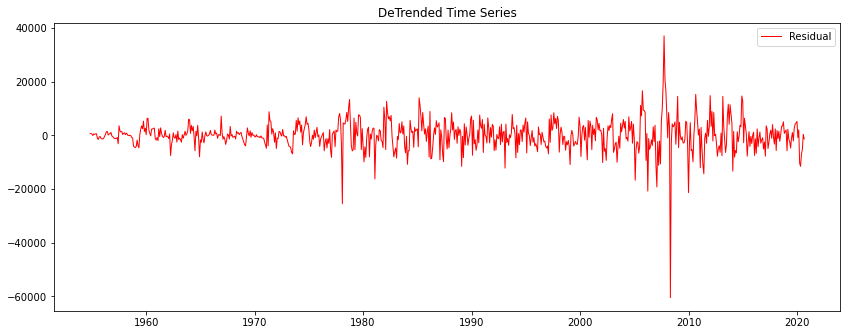

In [21]:
# Plot the detrended time series
plt.subplot(121)
orig = plt.plot(df_l[0]['residual'], color='red',linewidth = 1, label='Residual')
plt.title('DeTrended Time Series'); plt.legend(loc='best')
plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.0, wspace=0.2, hspace=0.2)
residual = df_l[0]['residual']

In [22]:
df_l[0].head(20)
df = df_l[0].dropna()
residual.dropna()
df.head(20)

,Prod,rolling_mean,residual
Date,,,
1954-11-01,3638.0,2962.65,675.35
1954-12-01,3698.0,3007.35,690.65
1955-01-01,3528.0,3059.50,468.50
1955-02-01,3030.0,3075.55,-45.55
1955-03-01,3579.0,3034.00,545.00
1955-04-01,3317.0,2940.75,376.25
1955-05-01,3365.0,2823.15,541.85
1955-06-01,3373.0,2762.85,610.15
1955-07-01,1724.0,2698.70,-974.70


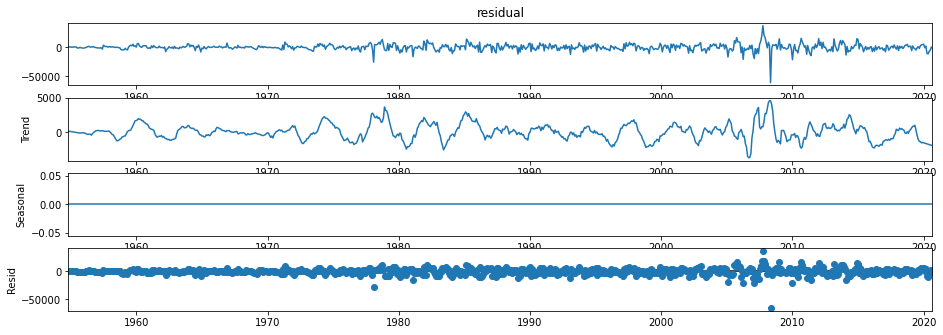

In [23]:
decomposition = seasonal_decompose(df['residual'], model='additive',extrapolate_trend=1,filt=np.ones(20)/20,two_sided = True, period = 1)
decomp_trend = decomposition.trend; decomp_seasonal = decomposition.seasonal; decomp_residual = decomposition.resid
fig = decomposition.plot()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

<AxesSubplot:xlabel='Date'>

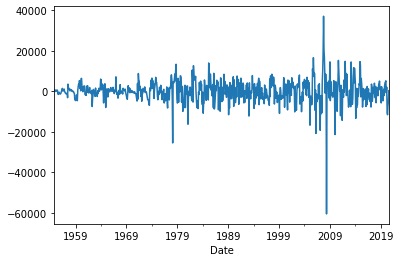

In [24]:
df['residual'].plot()

In [25]:
import warnings

warnings.filterwarnings("ignore")

Test RMSE: 7973.589


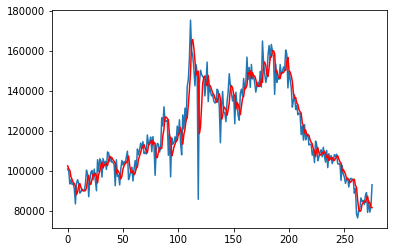

In [26]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(sk.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [27]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	print(t)
	model = ARIMA(history, order=(1,1,3))
	model_fit = model.fit()
	output = model_fit.forecast(steps=24)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
predictions=np.array(predictions)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [28]:
predictions.shape

(276, 24)

Test RMSE: 7952.777 for 1 month look ahead


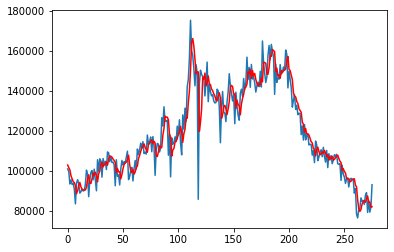

Test RMSE: 8783.901 for 2 month look ahead


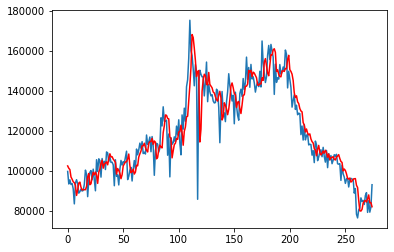

Test RMSE: 9547.215 for 3 month look ahead


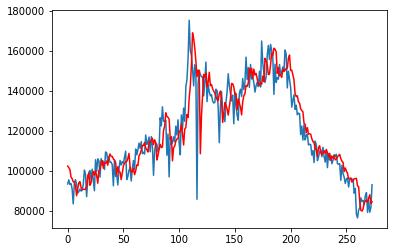

Test RMSE: 10375.470 for 4 month look ahead


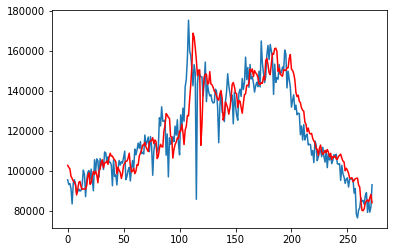

Test RMSE: 11123.495 for 5 month look ahead


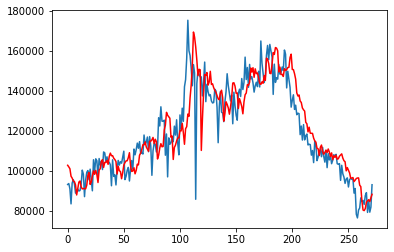

Test RMSE: 11972.521 for 6 month look ahead


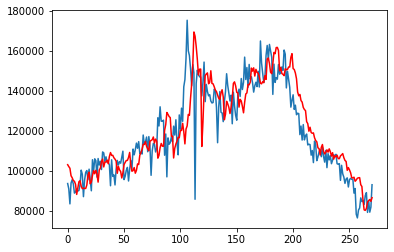

Test RMSE: 12502.017 for 7 month look ahead


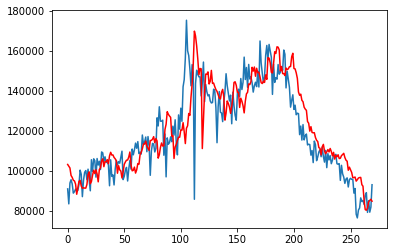

Test RMSE: 12686.716 for 8 month look ahead


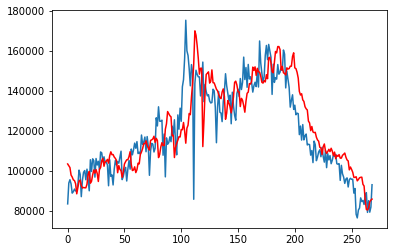

Test RMSE: 12549.754 for 9 month look ahead


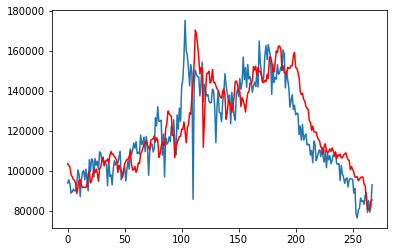

Test RMSE: 12903.665 for 10 month look ahead


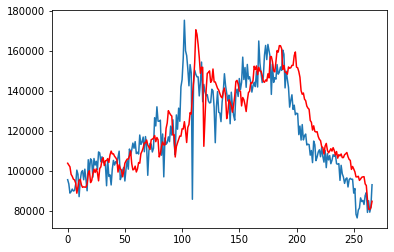

Test RMSE: 13360.901 for 11 month look ahead


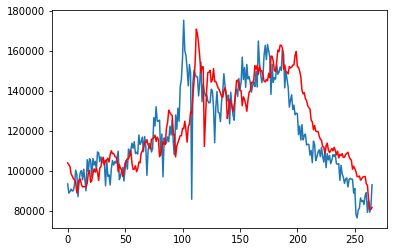

Test RMSE: 13595.527 for 12 month look ahead


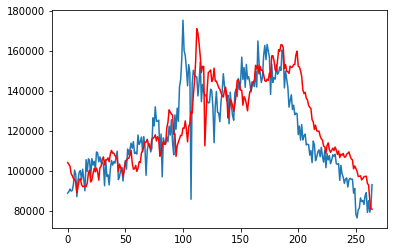

Test RMSE: 14306.357 for 13 month look ahead


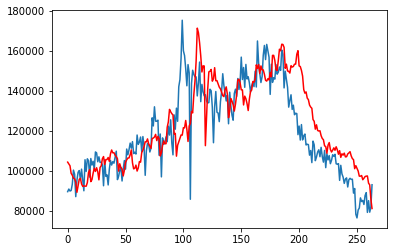

Test RMSE: 14649.354 for 14 month look ahead


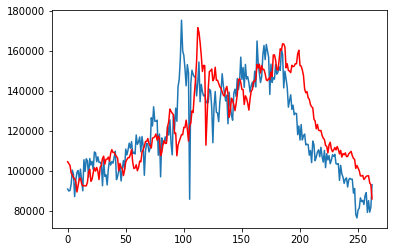

Test RMSE: 15245.570 for 15 month look ahead


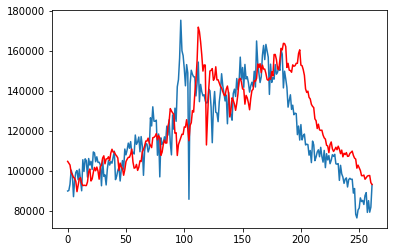

Test RMSE: 15951.742 for 16 month look ahead


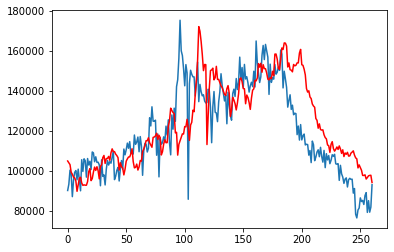

Test RMSE: 16591.771 for 17 month look ahead


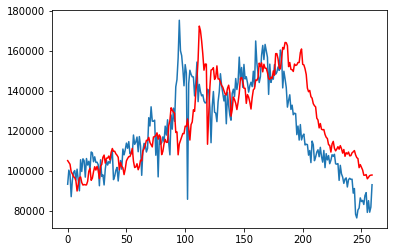

Test RMSE: 17056.385 for 18 month look ahead


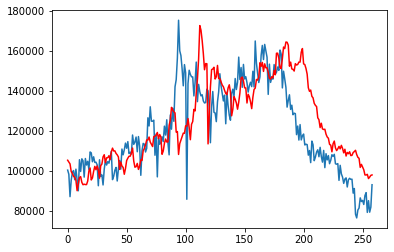

Test RMSE: 17268.514 for 19 month look ahead


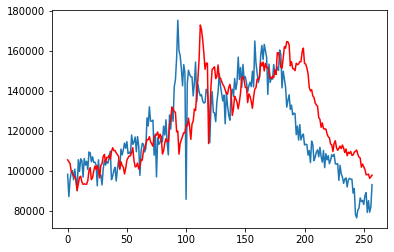

Test RMSE: 17628.240 for 20 month look ahead


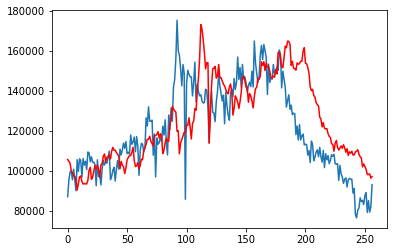

Test RMSE: 18230.270 for 21 month look ahead


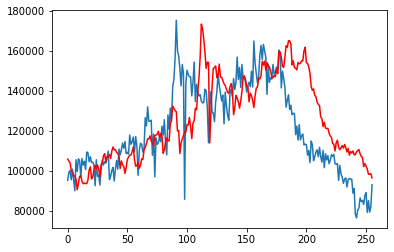

Test RMSE: 18588.779 for 22 month look ahead


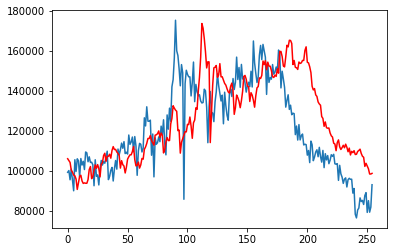

Test RMSE: 18999.256 for 23 month look ahead


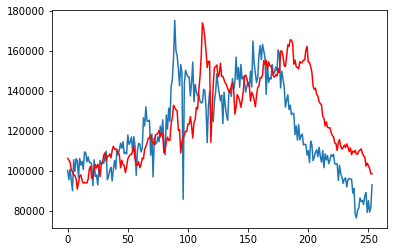

Test RMSE: 19370.998 for 24 month look ahead


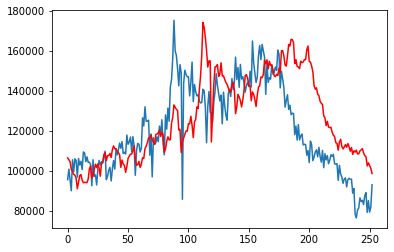

In [29]:
all_error=[]
for i in range(24):
    # evaluate forecasts
    rmse = math.sqrt(sk.mean_squared_error(test[i:], predictions[:predictions.shape[0]-i,i]))
    all_error.append(rmse)
    print('Test RMSE: %.3f for %d month look ahead' % (rmse,i+1))
    # plot forecasts against actual outcomes
    plt.plot(test[i:])
    plt.plot(predictions[:predictions.shape[0]-i,i], color='red')
    plt.show()

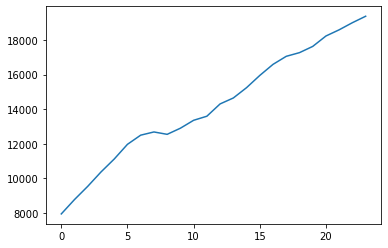

In [30]:
plt.plot(all_error)

In [34]:
#fit_rmse = math.sqrt((sk.mean_squared_error(test, predictions)))
dummy_rmse = math.sqrt(np.mean((month_prod.iloc[size+1:].values - month_prod.iloc[size:-1].values)**2))
#print('RMSE for ARIMA model:', fit_rmse)
print('Dummy RMSE:', dummy_rmse)

Dummy RMSE: 8901.257659674186


In [ ]:
size

In [ ]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(sk.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(sk.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
series = month_prod
# split into train and test sets
X = series.values
size = int(len(X) * .66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = math.sqrt(sk.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
pacf_n_acf_plots(month_prod, dif = 1)

In [ ]:
pacf_n_acf_plots(df['residual'], dif = 1)

In [37]:
diff1 = np.diff(df['Prod'].values)
diff1 = np.append(diff1,diff1[diff1.size-1])          # double the last value to keep the length the same
df['first_difference'] = diff1

diff2 = np.diff(df['first_difference'].values)
diff2 = np.append(diff2,diff2[diff2.size-1])          # double the last value to keep the length the same
df['second_difference'] = diff2
df.head()

,Prod,rolling_mean,residual,first_difference,second_difference
Date,,,,,
1954-11-01,3638.0,2962.65,675.35,60.0,-230.0
1954-12-01,3698.0,3007.35,690.65,-170.0,-328.0
1955-01-01,3528.0,3059.50,468.50,-498.0,1047.0
1955-02-01,3030.0,3075.55,-45.55,549.0,-811.0
1955-03-01,3579.0,3034.00,545.00,-262.0,310.0


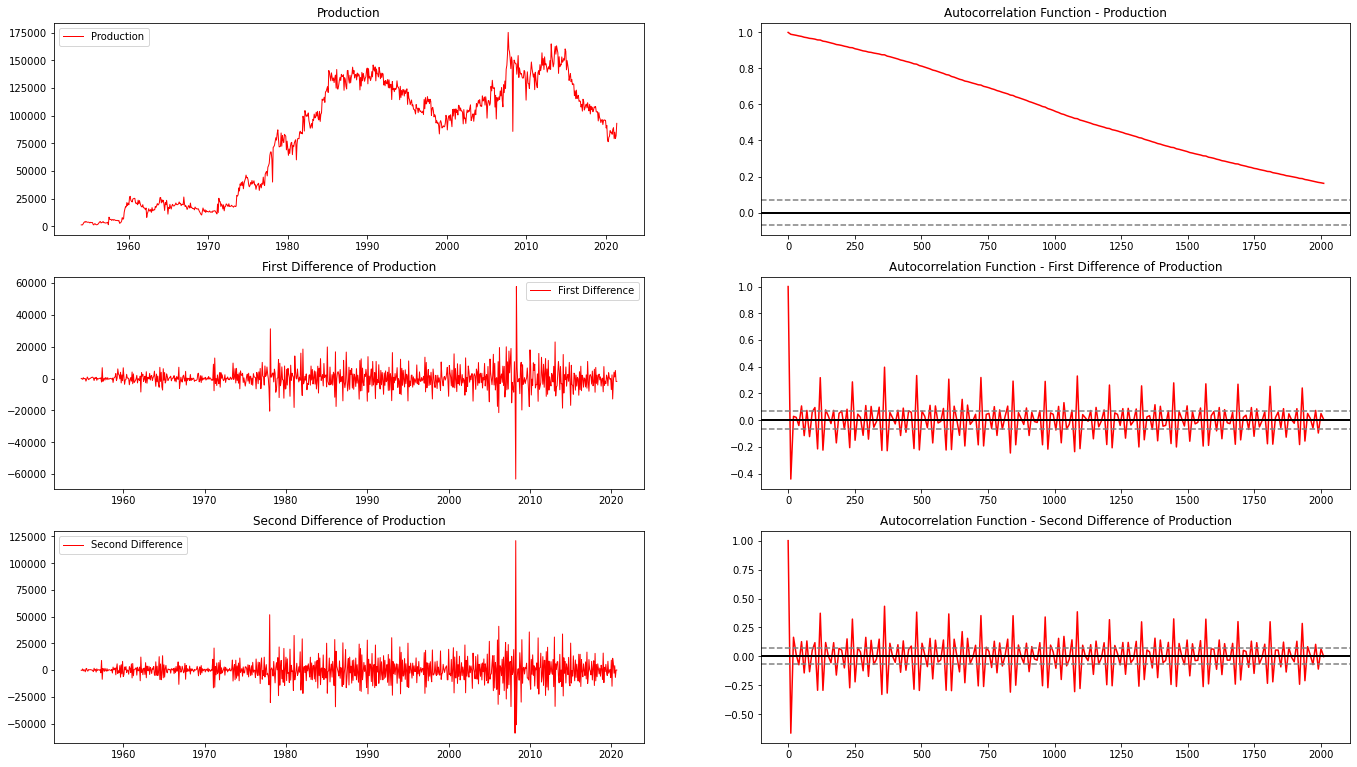

In [38]:
# Plot the first difference of the time series
from statsmodels.tsa.stattools import acf

nlags = 200
lags = np.linspace(0,(nlags+1)*xsiz,nlags+1)

prod_lag_acf = acf(df_l[0]['Prod'], nlags=nlags)
prod_d1_lag_acf = acf(df['first_difference'], nlags=nlags)
prod_d2_lag_acf = acf(df['second_difference'], nlags=nlags)

plt.subplot(321)
orig = plt.plot(df_l[0]['Prod'], color='red',linewidth = 1, label='Production')
plt.title('Production'); plt.legend(loc='best')

plt.subplot(322) 
plt.plot(lags,prod_lag_acf,color='red')
plt.axhline(y=0,linewidth = 2,color='black')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function - Production')

plt.subplot(323)
orig = plt.plot(df['first_difference'], color='red',linewidth = 1, label='First Difference')
plt.title('First Difference of Production'); plt.legend(loc='best')

plt.subplot(324) 
plt.plot(lags,prod_d1_lag_acf,color='red')
plt.axhline(y=0,linewidth = 2,color='black')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function - First Difference of Production')

plt.subplot(325)
orig = plt.plot(df['second_difference'], color='red',linewidth = 1, label='Second Difference')
plt.title('Second Difference of Production'); plt.legend(loc='best')

plt.subplot(326) 
plt.plot(lags,prod_d2_lag_acf,color='red')
plt.axhline(y=0,linewidth = 2,color='black')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function - Second Difference of Production')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.5, wspace=0.2, hspace=0.2)

In [ ]:
residual = residual.dropna()
residual.head(20)
residual